In [1]:
from source.feature_selection import stepwise_feature_selection, lasso, marginal_screening
from source.pipeline import make_dataset, make_pipeline, make_pipelines
import numpy as np

rng = np.random.default_rng(10)

X, y = make_dataset()
pl1 = make_pipeline(stepwise_feature_selection(X, y, 3, [1, 3, 5]))

X, y = make_dataset()
pl2 = make_pipeline(lasso(X, y, 0.08, [0.04, 0.08, 0.12]))

X, y = make_dataset()
pl3 = make_pipeline(marginal_screening(X, y, 3, [1, 3, 5]))

n, p = 200, 10
beta = np.zeros(p)
beta[:3] = 0.3
X = rng.normal(size=(n, p))
y = X @ beta + rng.normal(size=n)

pl1.tune(X, y, n_iter=3, random_state=0)
print(pl1.best_candidate, pl1.best_mse)
print(pl1.components[pl1.static_order[1]].parameters)
print()

multi_pls = make_pipelines(pl1, pl2, pl3)
multi_pls.tune(X, y, n_iters=3, random_state=0)
print(multi_pls.best_index)
print()

for pl in multi_pls.pipelines:
    print(pl.best_candidate, pl.best_mse)
    print(pl.components[pl.static_order[1]].parameters)
    print()

print(multi_pls)


{'stepwise_feature_selection_0': 3} 1.2088874635213522
3

2

{'stepwise_feature_selection_0': 3} 1.2088874635213522
3

{'lasso_0': 0.12} 1.1968544828111392
0.12

{'marginal_screening_0': 5} 1.1535464494537575
5

start -> stepwise_feature_selection_0
stepwise_feature_selection_0 -> end

start -> lasso_0
lasso_0 -> end

start -> marginal_screening_0
marginal_screening_0 -> end


In [8]:
from source.feature_selection import stepwise_feature_selection, lasso, marginal_screening
from source.pipeline import make_dataset, make_pipeline, make_pipelines
from source.model import option1, option2
import numpy as np

X, y = make_dataset()
mpls = make_pipelines(option1(), option2())


rng = np.random.default_rng()
n, p = 100, 10
beta = np.zeros(p)
beta[:3] = 0.0
X = rng.normal(size=(n, p))
y = X @ beta + rng.normal(size=n)
print(mpls(X, y))

mpls.tune(X, y, n_iters=1, cv=5, random_state=None)
print(mpls.best_index)
for pipeline in mpls.pipelines:
    print(pipeline.best_candidate, pipeline.best_mse)
M, O = mpls(X, y)
print(M)

print(mpls.inference(X, y, 1.0, test_index=rng.choice(len(M)), is_result=False))

[([2, 4, 8], [17, 35, 37, 39, 65, 72, 75]), ([2, 3, 4], [3, 10, 39, 62, 65, 79, 82])]
1
{} 1.2488417583080875
{} 1.1431496898203148
[2, 3, 4]
(4, 0.46953766683136156)


In [9]:
from source.feature_selection import stepwise_feature_selection, lasso, marginal_screening
from source.pipeline import make_dataset, make_pipeline, make_pipelines
from source.model import option1, option2
import numpy as np

X, y = make_dataset()
pl1 = make_pipeline(output=stepwise_feature_selection(X, y, 4, [2, 3, 4]))
pl2 = make_pipeline(output=marginal_screening(X, y, 4, [2,3,4]))
mpls = make_pipelines(pl1, pl2)


rng = np.random.default_rng()
n, p = 100, 10
beta = np.zeros(p)
beta[:3] = 0.0
X = rng.normal(size=(n, p))
y = X @ beta + rng.normal(size=n)
print(mpls(X, y))

mpls.tune(X, y, n_iters=3, cv=5, random_state=None)
print(mpls.best_index)
for pipeline in mpls.pipelines:
    print(pipeline.best_candidate, pipeline.best_mse)
M, O = mpls(X, y)
print(M)

print(mpls.inference(X, y, 1.0, test_index=rng.choice(len(M)), is_result=False))

[([6, 7, 0, 2], []), ([6, 7, 0, 2], [])]
0
{'stepwise_feature_selection_7': 2} 1.1826662159114336
{'marginal_screening_7': 2} 1.261441903356111
[6, 7]
(6, SelectiveInferenceResult(stat=1.3565843229362116, alpha=0.05, p_value=0.4191301192458007, inf_p=0.4191301192458007, sup_p=0.41987983116172023, reject_or_not=False, truncated_intervals=[[-3.518271926657677, -2.640291815352206], [-2.409179993122213, -0.8561904157662692], [0.8341090546677395, 1.8502078270347493], [2.0030245770539876, 3.4509854192446543]], search_count=73, detect_count=55, selected_model=None, mappings=None))


100%|██████████| 1000/1000 [07:42<00:00,  2.16it/s]

1000


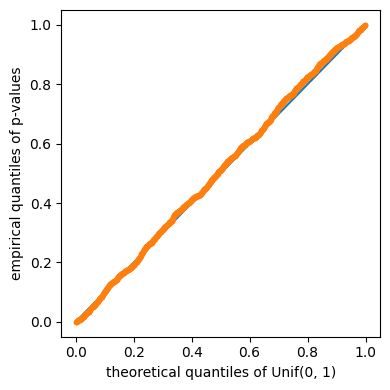

In [4]:
from source.feature_selection import stepwise_feature_selection, lasso, marginal_screening
from source.pipeline import make_dataset, make_pipeline, make_pipelines
from source.model import option1, option2
import numpy as np
from tqdm import tqdm
from sicore import pvalues_qqplot

X, y = make_dataset()
pl1 = make_pipeline(output=stepwise_feature_selection(X, y, 4, [2, 3, 4,5]))
pl2 = make_pipeline(output=marginal_screening(X, y, 4, [2,3,4,5]))
mpls = make_pipelines(pl1, pl2)


rng = np.random.default_rng()
n, p = 100, 10
beta = np.zeros(p)
beta[:3] = 0.0

p_list = []
for _ in tqdm(range(1000)):
    X = rng.normal(size=(n, p))
    y = X @ beta + rng.normal(size=n)
    mpls.tune(X, y, n_iters=4, cv=5, random_state=None)
    M, O = mpls(X, y)
    try:
        _, p_value = mpls.inference(X, y, 1.0, test_index=rng.choice(len(M)), is_result=False)
        p_list.append(p_value)
    except:
        pass

print(len(p_list))
pvalues_qqplot(p_list)


In [6]:
from scipy.stats import kstest

print(kstest(p_list, 'uniform'))
print(np.mean(np.array(p_list) < 0.05))

KstestResult(statistic=0.028528143466924227, pvalue=0.3826352587346791, statistic_location=0.7244718565330758, statistic_sign=1)
0.043


In [3]:
print(len(p_list))

896


In [4]:
from source.model import option1, option2
import source.pipelineprocesser as plp
from tqdm import tqdm
import numpy as np

X, y = plp.make_dataset()
pl = plp.make_pipeline(output=plp.stepwise_feature_selection(X, y, 4, [2, 3, 4, 5, 6]))

rng = np.random.default_rng(0)
n, p = 100, 10

beta = np.zeros(p)
beta[:5] = 0.0

results = []
for _ in tqdm(range(30000)):
    X = rng.normal(size=(n, p))
    y = X @ beta + rng.normal(size=n)

    pl.tune(X, y, n_iter=5, cv=3)
    M, _ = pl(X, y)
    if len(M) == 0:
        continue
    test_index = rng.choice(len(M))
    # if M[test_index] not in {0, 1, 2, 3, 4}:
    #     continue
    _, result = pl.inference(X, y, 1.0, test_index, step=1e-8)
    results.append(result)
    if len(results) == 2000:
        break

p_list = np.array([result.p_value for result in results])
print(np.mean(p_list < 0.05))


  7%|▋         | 1999/30000 [09:01<2:06:20,  3.69it/s]

0.048


In [1]:
from source.model import option1, option2
import source.pipelineprocesser as plp
from tqdm import tqdm
import numpy as np
from sicore import pvalues_qqplot

X, y = plp.make_dataset()
pl = plp.make_pipeline(output=plp.lasso(X, y, 0.08, [0.08, 0.12]))

rng = np.random.default_rng(0)
n, p = 150, 10

beta = np.zeros(p)
beta[:5] = 0.0

results = []
error_count = 0
for _ in tqdm(range(30000)):
    X = rng.normal(size=(n, p))
    y = X @ beta + rng.normal(size=n)

    pl.tune(X, y, n_iter=2, cv=3, random_state=0)
    M, _ = pl(X, y)
    if len(M) == 0:
        continue
    test_index = rng.choice(len(M))
    # if M[test_index] not in {0, 1, 2, 3, 4}:
    #     continue
    try:
        _, result = pl.inference(X, y, 1.0, test_index, step=1e-6, is_result=True)
        results.append(result)
    except:
        error_count += 1
    if len(results) == 500:
        break

print(error_count)
p_list = np.array([result.p_value for result in results])
print(np.mean(p_list < 0.05))
pvalues_qqplot(p_list)


  0%|          | 20/30000 [00:06<1:10:19,  7.10it/s]

In [4]:
from sicore import poly_lt_zero

for _ in range(1000):
    temp = poly_lt_zero([0, 0, 0], 1e-8)
print(temp)

[[-inf, inf]]


In [4]:
temp = 0
flag = False
for i in range(10):
    if i == 3:
        flag = True

    if flag:
        continue
    temp += 1
print(temp)

3


2000
KstestResult(statistic=0.014692496174715575, pvalue=0.7751781296729825, statistic_location=0.6946924961747156, statistic_sign=-1)


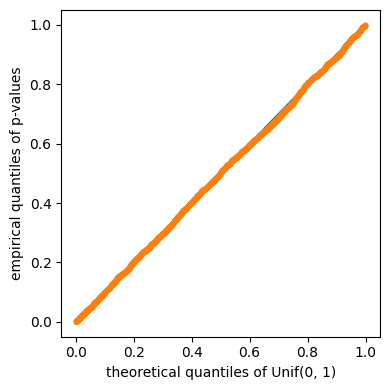

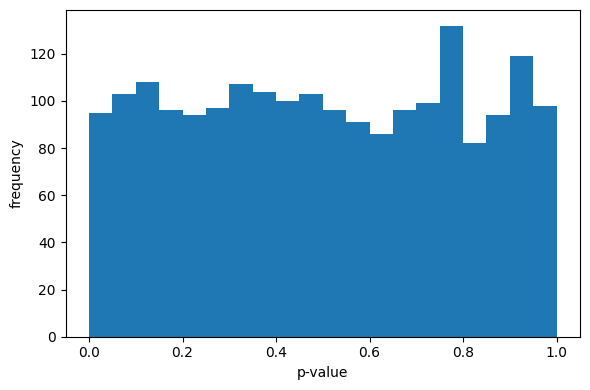

In [2]:
from sicore import pvalues_qqplot, pvalues_hist
from scipy.stats import kstest

print(len(p_list))
print(kstest(p_list, 'uniform'))
pvalues_qqplot(p_list)
pvalues_hist(p_list)


In [ ]:
import numpy as np


In [12]:
intervals = dict()
intervals.setdefault(1, dict())
intervals[1].setdefault(2, dict())
print(intervals)
print(intervals[1][2])

intervals.setdefault(1, dict())
intervals[1].setdefault(2, dict())
print(intervals)
print(intervals[1][2])

intervals[None] = 3

for key, value in intervals[1][2].items():
    print(key, value)

print(intervals[None])


{1: {2: {}}}
{}
{1: {2: {}}}
{}
3
